In [ ]:
  from numba import cuda 
device = cuda.get_current_device()
device.reset()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7790148407809077477
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18010439523774081543
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [45]:
!pip install segmentation_models
!pip install "opencv-python-headless<4.3"
!pip install albumentations==1.1.0
!pip install tta-wrapper

  Using cached opencv_python_headless-3.4.17.63-cp36-abi3-win_amd64.whl (31.2 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\bon\\Anaconda3\\envs\\komtuveu\\Lib\\site-packages\\~.2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-win_amd64.whl (35.3 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 3.4.17.63
    Uninstalling opencv-python-headless-3.4.17.63:
      Successfully uninstalled opencv-python-headless-3.4.17.63


In [46]:
%env SM_FRAMEWORK=tf.keras
import albumentations as A
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.metrics import jaccard_score as js
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.image import extract_patches as ep
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import tifffile as tiff
import time

env: SM_FRAMEWORK=tf.keras


In [53]:
import matplotlib
print(matplotlib.__version__)

3.5.1


In [47]:
AUGMENTATIONS_TRAIN =A.Compose([
                                A.OneOf([
                                         A.ShiftScaleRotate (p=.8),
                                         A.ElasticTransform (p=.8),
                                         A.OpticalDistortion(p=.8),
                                         A.GridDistortion   (p=.8)
                                         ]),
                                A.RandomGamma(p=.66),
                                A.RandomGridShuffle(p=.3),
                                A.HorizontalFlip(p=.5),
                                A.Blur(p=0.3),
                                A.Cutout(p=0.2),
                                A.GaussNoise(p=0.3)
                                ])

AUGMENTATIONS_TEST = A.Compose([
                                # A.ToFloat(max_value=255)
                                A.NoOp()
                                ])

In [48]:
dataim=tiff.imread("training.tif")
datalb=tiff.imread("training_groundtruth.tif")

def load_data(x,y,split=.8):
    xt,xv,yt,yv = train_test_split(x,y,test_size=1-split,random_state=42)
    xt=np.expand_dims(xt,-1)
    xt=np.concatenate((xt,xt,xt),axis=3)
    xv=np.expand_dims(xv,-1)
    xv=np.concatenate((xv,xv,xv),axis=3)
    yt=np.expand_dims(yt,-1)
    yv=np.expand_dims(yv,-1)
    return xt,yt,xv,yv
images,masks=[],[]
for i in range(len(dataim)):
    images.append((dataim[i]).astype("uint8"))
    datalb[i][datalb[i]!=0]=1 #255=>1
    masks.append(datalb[i].astype("uint8")) 
x_train,y_train,x_val,y_val=load_data(images,masks)
del dataim,datalb
del images,masks
gc.collect()

50954

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Tile:
    '''
    Usage    : Tile(image,tilesize,overlap,verbose)
    image    : Array of shape [length,width,canals]
    tilesize : The output will be of shape [tilesize,tilesize,canals]
    overlap  : Amount of pixel common between two consecutive tiles
    ================================================================
    Methods  :
    padding(mode="reflect"): Returns a padded image via numpy.pad usage
    tilegeneration()       : Returns a list parts of original image(tiles)
    tilevis(concat=True)   : Plots the tiles list for the image
    detmask()              : Returns the mask of overlapping areas
    reconstruct()          : Builds the image back out of the tile list   
    '''
    
    def __init__(self, image, tilesize=None,overlap=None,verbose=False):
        
        self.im = image
        self.s  = np.shape(self.im)[:2]
        if tilesize is None:tilesize=self.s[0]//4
        self.t  = tilesize
        if overlap is None :overlap =tilesize//4
        self.o  = overlap
        self.verbose=verbose
        self.verdata()
        self.to = self.t-self.o
        self.nbt= [(self.s[0]-self.o)//self.to+1,(self.s[1]-self.o)//self.to+1]
        self.p  = None
        self.pIm= None
        self.tl = None
        
    def verdata(self):
        if (np.shape(self.im)[0]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis zero.")
            self.im=self.im[:-1]
        if (np.shape(self.im)[1]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis one.")
            self.im=self.im[:,:-1]
        if self.o%2!=0:
            if self.verbose:print("Please use even value for overlap, overlap was reduced by one.")
            self.o-=1
        if self.t>np.shape(self.im)[0] or self.t>np.shape(self.im)[1]:
            if self.verbose:print("You probably didn't do what you want, you will just have one padded image. (Tile size larger than image)")
                      
    def detpad(self):
        psize=[(self.nbt[0]*self.to+self.o)-self.s[0],(self.nbt[1]*self.to+self.o)-self.s[1]]
        for i in range(len(psize)):
            if  psize[i]==self.to:
                psize[i]%=self.to
                self.nbt[i]-=1
        return psize
    
    def padding(self,mode="reflect"):
        if self.p is None:
            self.p=self.detpad()
        padval=int(self.p[0]/2),int(self.p[1]/2)
        pIm=np.pad(self.im,((padval[0],padval[0]),(padval[1],padval[1]),(0,0)),mode=mode)
        return pIm
    
    def tilegeneration(self):
        if self.pIm is None:
            self.pIm=self.padding()
        tiles=[]
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                tiles.append(self.pIm[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t])
        return tiles
    
    def tilevis(self,concat=True):
        if self.tl is None:
            self.tl=self.tilegeneration()
        plt.figure(figsize =( 3*self.nbt[1], 3*self.nbt[0]))
        if not concat:
            for i in range(self.nbt[0]):
                for j in range(self.nbt[1]):
                    ax = plt.subplot(self.nbt[0], self.nbt[1], i*self.nbt[1]+j+1)
                    ax.axis("off")
                    plt.imshow(self.tl[i*self.nbt[1]+j])
        else:
            im=[]
            for i in range(self.nbt[0]):
                line=[]
                for j in range(self.nbt[1]):
                    if j==0: line=self.tl[i*self.nbt[1]+j]
                    else: line = np.concatenate((line,self.tl[i*self.nbt[1]+j]),axis=1)
                if i==0:im=line
                else:im=np.concatenate((im,line),axis=0)
            plt.imshow(im)
        plt.show()
        
    
    def detmask(self):
        if self.pIm is None:
            self.pIm=self.padding()
        mask=np.zeros(np.shape(self.pIm)[:2])
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                mask[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=np.ones((self.t,self.t))
        return mask[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
    
    def reconstruct(self):
        if self.tl is None:
            self.tl=self.tilegeneration()
        reim=np.zeros(np.shape(self.pIm))
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                reim[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=self.tl[i*self.nbt[1]+j]
        reim=reim[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
        mask=self.detmask()
        for i in range(np.shape(reim)[2]):
            reim[...,i]/=mask
        return reim.astype(int)


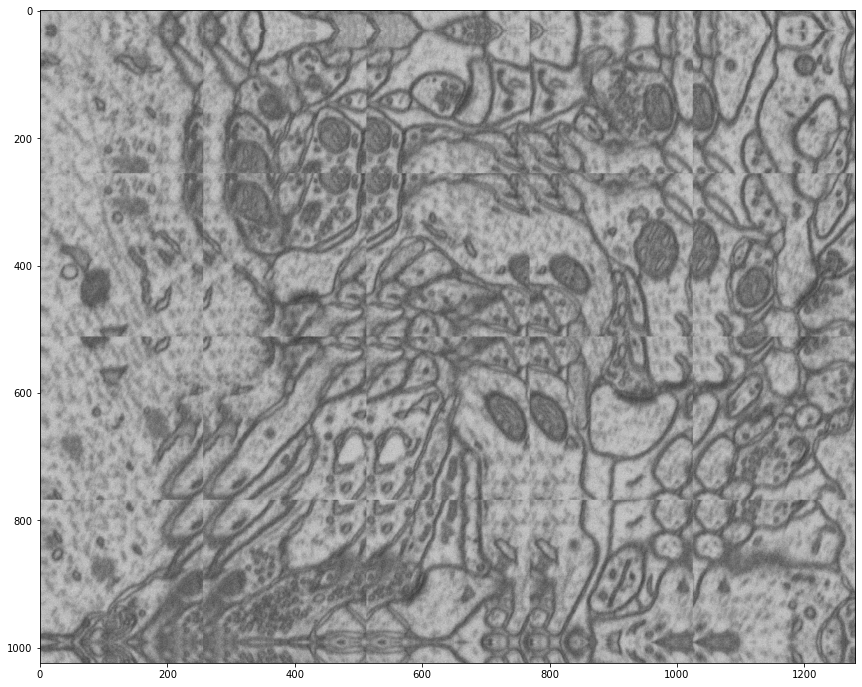

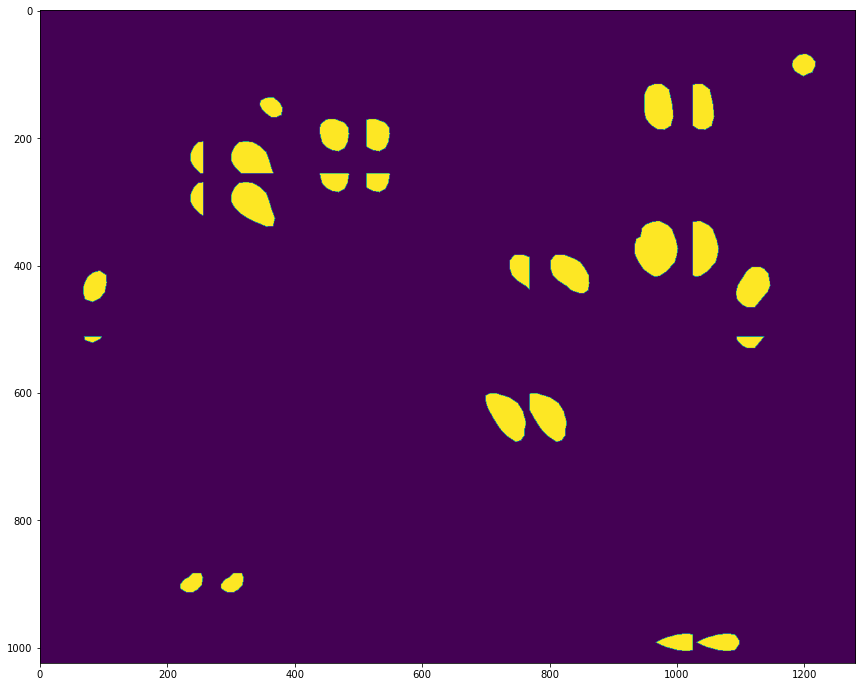

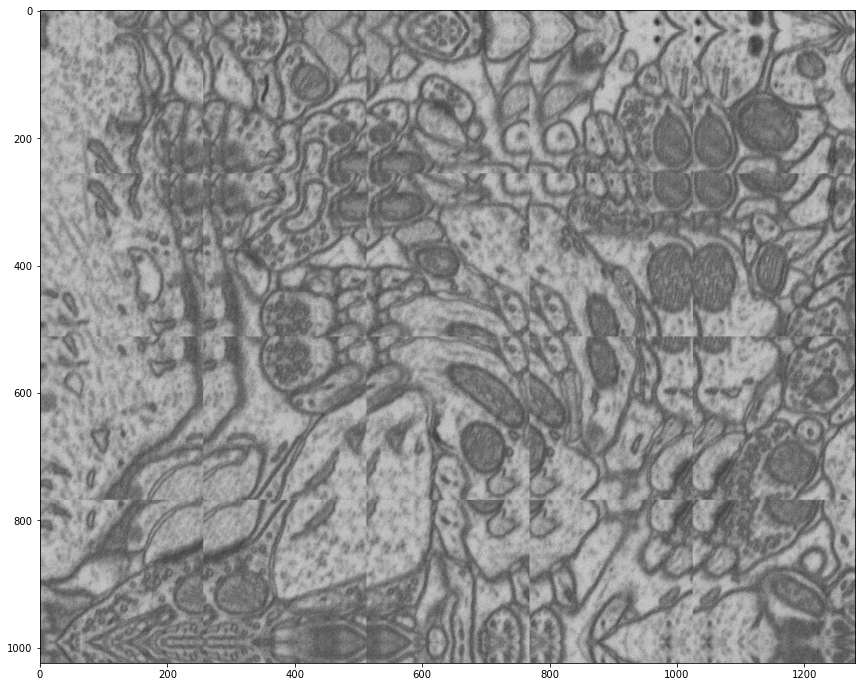

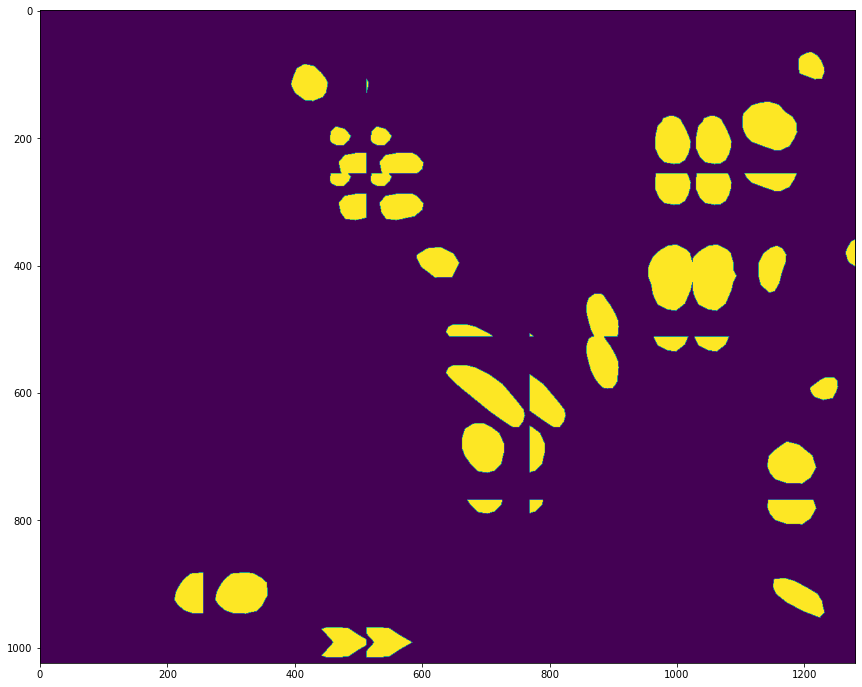

In [50]:
def tiling(dataset,tilesize=256,overlap=64):
    
    tiled=[]
    for i in dataset:
        tempi=Tile(i,tilesize,overlap)
        tiled.append(tempi.tilegeneration())
    tempi.tilevis()
    return np.reshape(tiled,(-1,tilesize,tilesize,np.shape(dataset)[-1]))
x_train,y_train,x_val,y_val=tiling(x_train),tiling(y_train),tiling(x_val),tiling(y_val)

# Sequence Class

In [18]:
class CIFAR10Sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        img_orig=[]
        msk_orig=[]
        img=[]
        msk=[]
        for i in range(batch_x.shape[0]):
            # print(batch_x[i].dtype, batch_y[i].dtype)
            img_orig.append(batch_x[i])
            msk_orig.append(batch_y[i])
            agm = self.augment(image=batch_x[i], mask=batch_y[i])
            img.append(agm["image"])
            msk.append(agm["mask"])
        img=np.array(img)
        msk=np.array(msk)
        img_orig=np.array(img_orig)
        msk_orig=np.array(msk_orig)
        img=sm.get_preprocessing("efficientnetb0")(img)
        return img.astype("float32"),msk.astype("float32")


In [19]:
model = Unet('efficientnetb0',encoder_weights="imagenet",activation="sigmoid", input_shape=(None, None, x_train.shape[-1]))
model.compile(Adam(learning_rate=1e-4), loss=bce_jaccard_loss, metrics=[iou_score])
checkpoint_filepath = '/tmp/checkpoint'

es_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

16818176/16804768 [==============================] - 2s 0us/step


In [20]:
train_gen = CIFAR10Sequence(x_train, y_train, batch_size=32, augmentations=AUGMENTATIONS_TRAIN)
valid_gen = CIFAR10Sequence(x_val, y_val, batch_size=32, augmentations=AUGMENTATIONS_TEST)

# Fit the model on the batches generated by datagen.flow().
history1 = model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=[es_callback])

Epoch 1/100
 3/83 [>.............................] - ETA: 11:38 - loss: 1.4997 - iou_score: 0.0557

KeyboardInterrupt: 

In [ ]:
model.save("/content/gdrive/MyDrive/segmAugTile100")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/segmAugTile100/assets


In [ ]:
model.compile(Adam(learning_rate=1e-5), loss=bce_jaccard_loss, metrics=[iou_score])
# Fit the model on the batches generated by datagen.flow().
history2 = model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=es_callback)

Epoch 1/100
99/99 [==============================] - 151s 1s/step - loss: 0.1175 - iou_score: 0.9016 - val_loss: 0.0932 - val_iou_score: 0.9225
Epoch 2/100
99/99 [==============================] - 133s 1s/step - loss: 0.1180 - iou_score: 0.9015 - val_loss: 0.0928 - val_iou_score: 0.9230
Epoch 3/100
99/99 [==============================] - 133s 1s/step - loss: 0.1180 - iou_score: 0.9017 - val_loss: 0.0927 - val_iou_score: 0.9232
Epoch 4/100
99/99 [==============================] - 133s 1s/step - loss: 0.1153 - iou_score: 0.9038 - val_loss: 0.0928 - val_iou_score: 0.9232
Epoch 5/100
99/99 [==============================] - 133s 1s/step - loss: 0.1144 - iou_score: 0.9045 - val_loss: 0.0927 - val_iou_score: 0.9233
Epoch 6/100
99/99 [==============================] - 134s 1s/step - loss: 0.1147 - iou_score: 0.9043 - val_loss: 0.0922 - val_iou_score: 0.9238
Epoch 7/100
99/99 [==============================] - 133s 1s/step - loss: 0.1119 - iou_score: 0.9065 - val_loss: 0.0922 - val_iou_score:

In [38]:
load=True
if load:
    from tensorflow.keras.models import load_model
    model=load_model("segmAugTile100+100",custom_objects={
      "binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss,
      "iou_score": sm.metrics.iou_score
    })

In [ ]:
model.save("/content/gdrive/MyDrive/segmAugTile100+100")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/segmAugTile100+100/assets


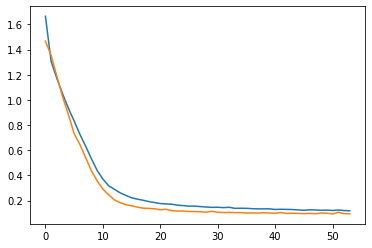

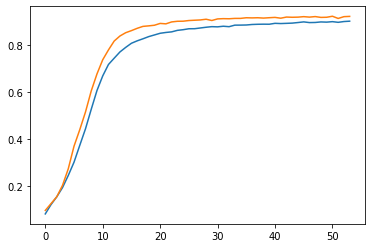

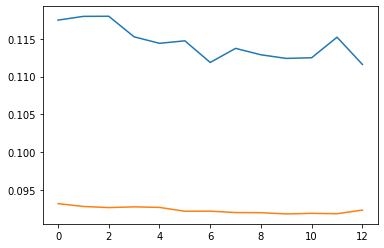

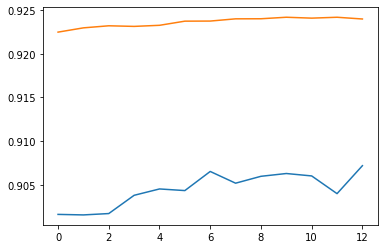

In [ ]:
for h in [history1,history2]:
    losscurve,ioucurve,vlosscurve,vioucurve=h.history["loss"],h.history["iou_score"],h.history["val_loss"],h.history["val_iou_score"]
    plt.figure()
    plt.plot(losscurve)
    plt.plot(vlosscurve)
    plt.figure()
    plt.plot(ioucurve)
    plt.plot(vioucurve)
    plt.show()

In [35]:
testim=tiff.imread("testing.tif")
testlb=tiff.imread("testing_groundtruth.tif")

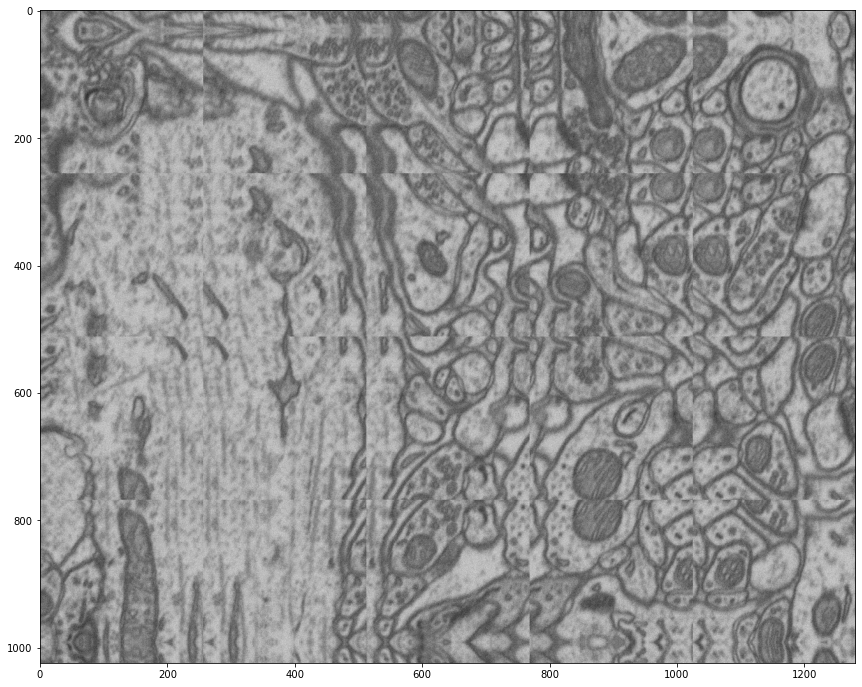

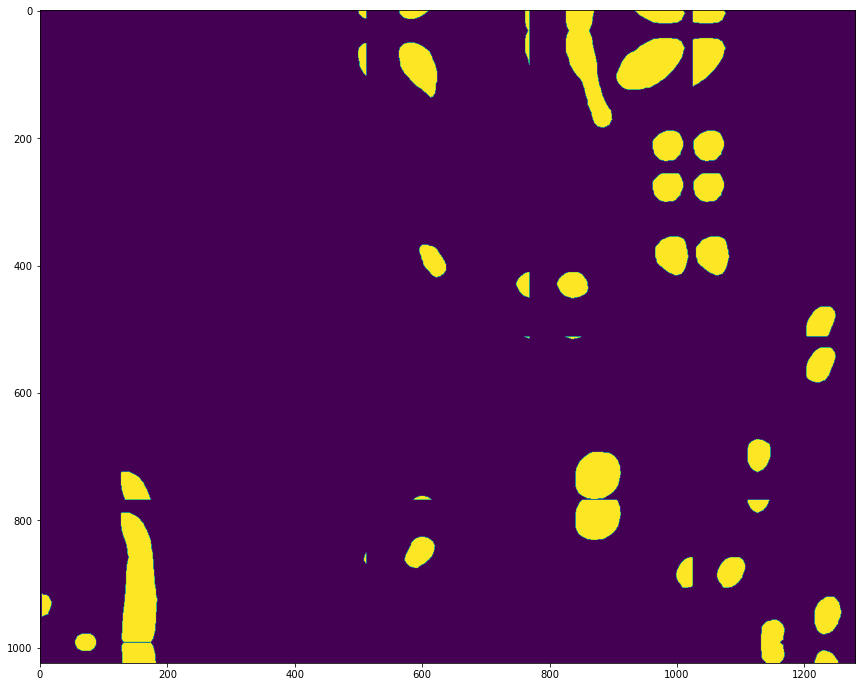

(1640, 256, 256, 3) (1640, 256, 256, 1)


In [36]:
from segmentation_models import get_preprocessing
timages,tmasks=[],[]
for i in testim:timages.append(i)
for i in testlb:
    i[i!=0]=1
    tmasks.append(i)
del testim,testlb
gc.collect()
x_test=np.expand_dims(timages[:int(len(timages)/2)],-1)
y_test=np.expand_dims(tmasks[:int(len(tmasks)/2)],-1)
x_test=np.concatenate((x_test,x_test,x_test),axis=3)
x_test,y_test=tiling(x_test),tiling(y_test)
print(np.shape(x_test),np.shape(y_test))
preprocess_input = get_preprocessing('efficientnetb0')
x_test = preprocess_input(x_test)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class Tile:
    '''
    Usage    : Tile(image,tilesize,overlap,verbose)
    image    : Array of shape [length,width,canals]
    tilesize : The output will be of shape [tilesize,tilesize,canals]
    overlap  : Amount of pixel common between two consecutive tiles
    ================================================================
    Methods  :
    padding(mode="reflect"): Returns a padded image via numpy.pad usage
    tilegeneration()       : Returns a list parts of original image(tiles)
    tilevis(concat=True)   : Plots the tiles list for the image
    detmask()              : Returns the mask of overlapping areas
    reconstruct()          : Builds the image back out of the tile list   
    '''
    
    def __init__(self, image, tilesize=None,overlap=None,verbose=False):
        
        self.im = image
        self.s  = np.shape(self.im)[:2]
        if tilesize is None:tilesize=self.s[0]//4
        self.t  = tilesize
        if overlap is None :overlap =tilesize//4
        self.o  = overlap
        self.verbose=verbose
        self.verdata()
        self.to = self.t-self.o
        self.nbt= [(self.s[0]-self.o)//self.to+1,(self.s[1]-self.o)//self.to+1]
        self.p  = None
        self.pIm= None
        self.tl = None
        
    def verdata(self):
        if (np.shape(self.im)[0]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis zero.")
            self.im=self.im[:-1]
        if (np.shape(self.im)[1]%2)!=0:
            if self.verbose:print("Changing image to an even dimension value, one pixel was removed on axis one.")
            self.im=self.im[:,:-1]
        if self.o%2!=0:
            if self.verbose:print("Please use even value for overlap, overlap was reduced by one.")
            self.o-=1
        if self.t>np.shape(self.im)[0] or self.t>np.shape(self.im)[1]:
            if self.verbose:print("You probably didn't do what you want, you will just have one padded image. (Tile size larger than image)")
                      
    def detpad(self):
        psize=[(self.nbt[0]*self.to+self.o)-self.s[0],(self.nbt[1]*self.to+self.o)-self.s[1]]
        for i in range(len(psize)):
            if  psize[i]==self.to:
                psize[i]%=self.to
                self.nbt[i]-=1
        return psize
    
    def padding(self,mode="reflect"):
        if self.p is None:
            self.p=self.detpad()
        padval=int(self.p[0]/2),int(self.p[1]/2)
        pIm=np.pad(self.im,((padval[0],padval[0]),(padval[1],padval[1]),(0,0)),mode=mode)
        return pIm
    
    def tilegeneration(self):
        if self.pIm is None:
            self.pIm=self.padding()
        tiles=[]
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                tiles.append(self.pIm[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t])
        return tiles
    
    def tilevis(self,concat=True):
        if self.tl is None:
            self.tl=self.tilegeneration()
        plt.figure(figsize =( 3*self.nbt[1], 3*self.nbt[0]))
        if not concat:
            for i in range(self.nbt[0]):
                for j in range(self.nbt[1]):
                    ax = plt.subplot(self.nbt[0], self.nbt[1], i*self.nbt[1]+j+1)
                    ax.axis("off")
                    plt.imshow(self.tl[i*self.nbt[1]+j])
        else:
            im=[]
            for i in range(self.nbt[0]):
                line=[]
                for j in range(self.nbt[1]):
                    if j==0: line=self.tl[i*self.nbt[1]+j]
                    else: line = np.concatenate((line,self.tl[i*self.nbt[1]+j]),axis=1)
                if i==0:im=line
                else:im=np.concatenate((im,line),axis=0)
            plt.imshow(im)
        plt.show()
        
    
    def detmask(self):
        if self.pIm is None:
            self.pIm=self.padding()
        mask=np.zeros(np.shape(self.pIm)[:2])
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                mask[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=np.ones((self.t,self.t))
        return mask[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
    
    def reconstruct(self,self.tl=self.tl):
        if self.tl is None:
            self.tl=self.tilegeneration()
        reim=np.zeros(np.shape(self.pIm))
        for i in range (self.nbt[0]):
            for j in range (self.nbt[1]):
                reim[i*self.to:i*self.to+self.t,j*self.to:j*self.to+self.t]+=self.tl[i*self.nbt[1]+j]
        reim=reim[int(self.p[0]/2):self.s[0]+int(self.p[0]/2),int(self.p[1]/2):self.s[1]+int(self.p[1]/2)]
        mask=self.detmask()
        for i in range(np.shape(reim)[2]):
            reim[...,i]/=mask
        return reim.astype(int)


In [40]:
model.evaluate(x_test.astype("float32"),y_test.astype("float32"))

52/52 [==============================] - 122s 2s/step - loss: 0.2621 - iou_score: 0.8056


[0.2621457278728485, 0.80556720495224]

ground_truth 0


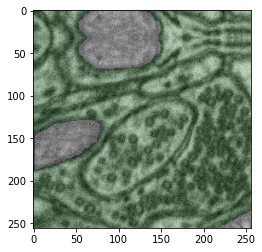

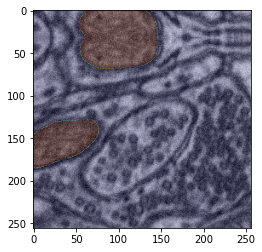

ground_truth 1


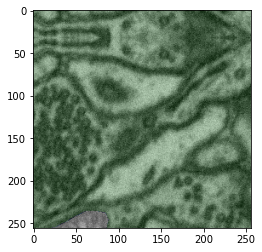

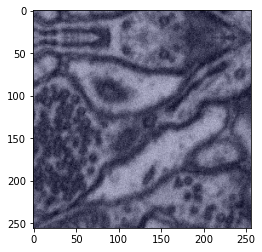

ground_truth 2


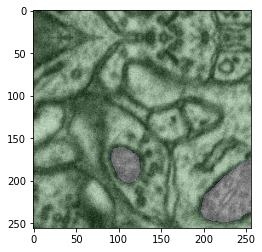

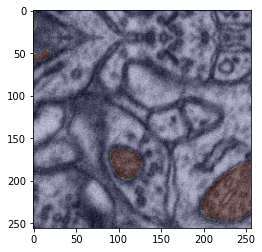

ground_truth 3


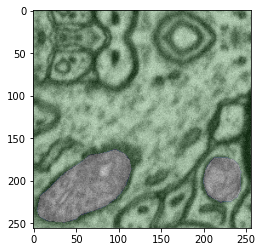

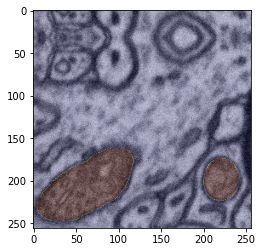

ground_truth 4


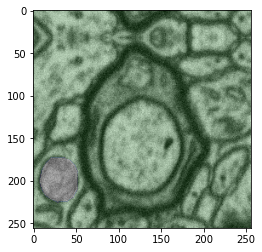

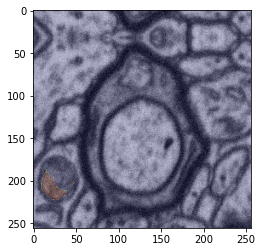

ground_truth 5


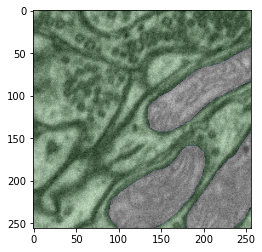

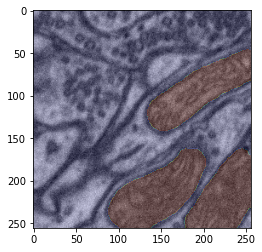

ground_truth 6


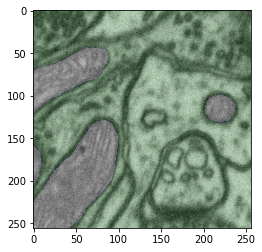

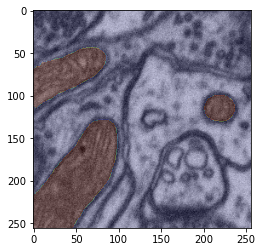

ground_truth 7


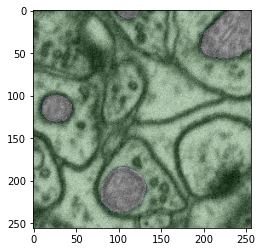

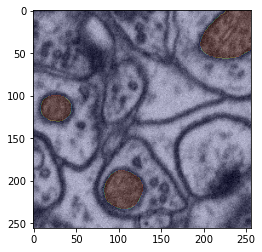

ground_truth 8


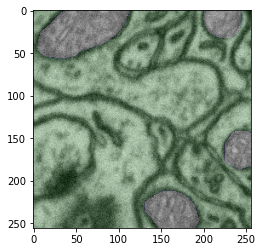

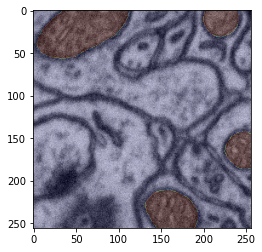

ground_truth 9


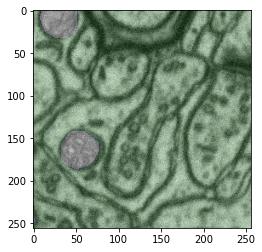

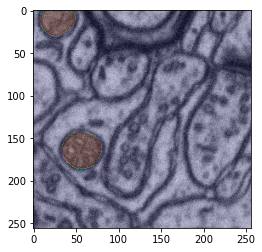

In [41]:
res=model.predict(x_test,batch_size=64)
for i in range(10):
    print("ground_truth",i)
    plt.figure()
    plt.imshow(x_test[i,...,0],cmap="gray")
    plt.imshow(y_test[i,...,0],cmap="ocean",alpha=.2)
    plt.figure()
    plt.imshow(x_test[i,...,0],cmap="gray")
    plt.imshow(res[i,...,0]>.5,alpha=.2,cmap="jet")
    plt.show()

In [44]:
model.evaluate(x_val,y_val.astype("float32"))

21/21 [==============================] - 48s 2s/step - loss: 0.1191 - iou_score: 0.9043


[0.11914847046136856, 0.9043118357658386]

In [43]:
x_val=get_preprocessing("efficientnetb0")(x_val)
res=model.predict(x_val,batch_size=16)

ground_truth 0


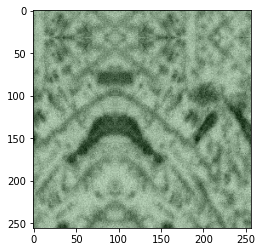

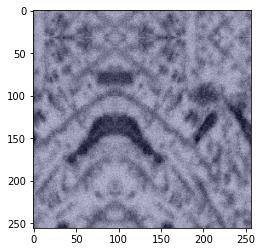

ground_truth 1


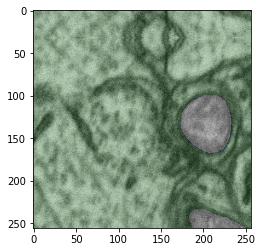

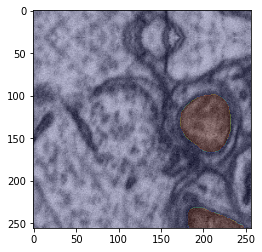

ground_truth 2


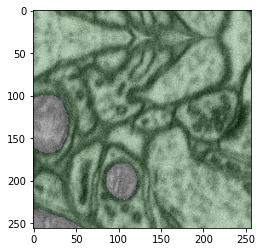

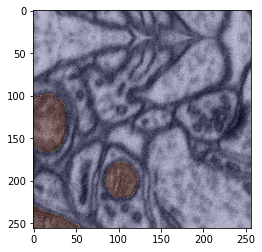

ground_truth 3


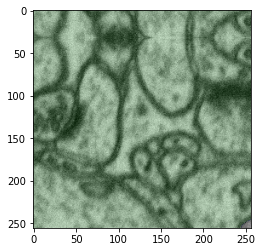

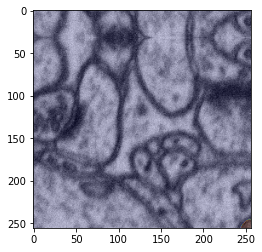

ground_truth 4


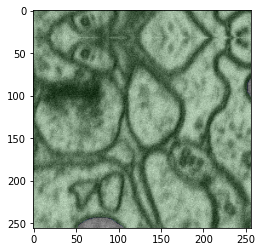

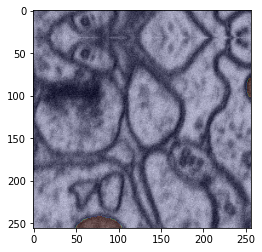

ground_truth 5


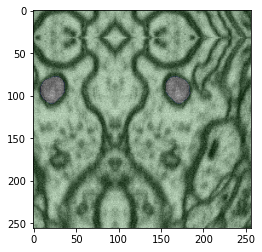

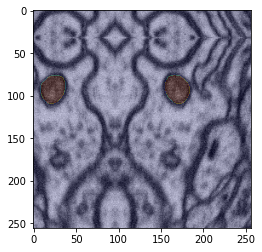

ground_truth 6


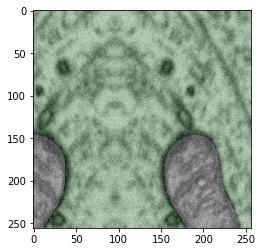

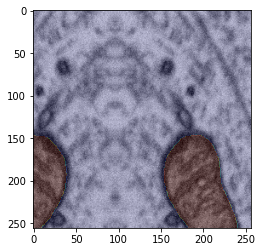

ground_truth 7


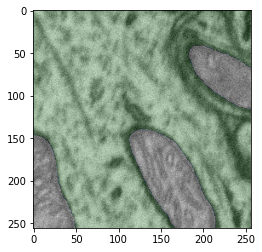

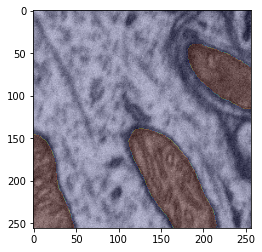

ground_truth 8


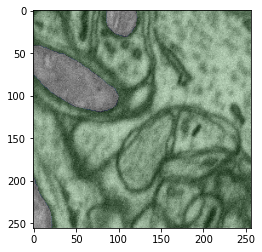

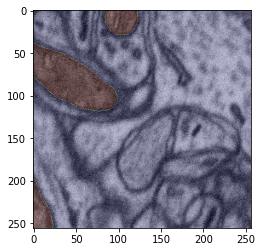

ground_truth 9


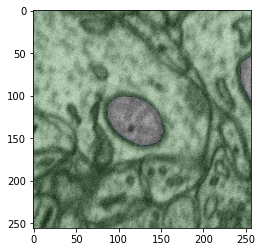

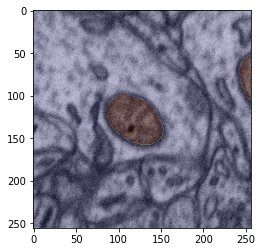

In [ ]:
for i in range(10):
    print("ground_truth",i)
    plt.figure()
    plt.imshow(x_val[i,...,0],cmap="gray")
    plt.imshow(y_val[i,...,0],cmap="ocean",alpha=.2)
    plt.figure()
    plt.imshow(x_val[i,...,0],cmap="gray")
    plt.imshow(res[i,...,0]>.5,alpha=.2,cmap="jet")
    plt.show()

In [ ]:
res_=np.copy(res).squeeze(axis=3)
score=0

res_[res_>.5]=1
res_[res_<=.5]=0
for i in range(res_.shape[0]):
  score+=js(res_[i].flatten(),y_val[i].squeeze().flatten())
print(score/len(res_))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard 

0.6583625852545256


In [ ]:
import scipy as sp

In [ ]:
def flip_lr(images):
    return np.flip(images, axis=2)

def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def rotate(images, angle):
    return sp.ndimage.rotate(
        images, angle, axes=(1,2),
        reshape=False, mode='nearest')

In [ ]:
import gc
del Xtest,pred
gc.collect()

NameError: ignored

In [ ]:
pred= model.predict(Xtest,batch_size=8)/6

In [ ]:
flip = flip_lr(Xtest)
pred+= flip_lr(model.predict(flip,batch_size=8))/6
del flip
gc.collect()
shiftw0=shift(Xtest, -30, axis=2)
pred+=shift(model.predict(shiftw0,batch_size=8), 30,axis=2)/6
del shiftw0
gc.collect()
shiftw1=shift(Xtest,  30, axis=2)
pred+=shift(model.predict(shiftw1,batch_size=8),-30,axis=2)/6
del shiftw1
gc.collect()
shifth0=shift(Xtest, -30, axis=1)
pred+=shift(model.predict(shifth0,batch_size=8), 30,axis=1)/6
del shifth0
gc.collect()
shifth1=shift(Xtest,  30, axis=1)
pred+=shift(model.predict(shifth1,batch_size=8),-30,axis=1)/6
del shifth1
gc.collect()
"""
rotate0 = rotate(Xtest, -10)
pred+= rotate(model.predict(rotate0,batch_size=8), 10)/8
del rotate0
gc.collect()
rotate1 = rotate(Xtest,  10)
pred+= rotate(model.predict(rotate1,batch_size=8),-10)/8
del rotate1
gc.collect()
"""

In [ ]:
for i in range(10):
  print("ground_truth",i)
  plt.figure()
  plt.imshow(ytest[i,...,0])
  plt.show()
  print("predict",i)
  plt.figure()
  plt.imshow(pred[i,...,0])
  plt.show()

In [ ]:
res_=np.copy(pred).squeeze(axis=3)
score=0

res_[res_>.5]=1
res_[res_<=.5]=0
for i in range(res_.shape[0]):
  score+=js(res_[i].flatten(),tmasks[i].flatten())
print(score/len(res_))